In [1]:
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)


In [2]:
fname = 'D:/SLAC/hysteresis/magnet_characterization/1.26Q3.5_4034/strplt.ru1'

data = []
with open(fname,'r') as f:
    f.readline()
    for line in f:
        temp = line.rstrip().split(' ')
        d = []
        for ele in temp:
            if ele != '':
                d += [ele]
        data += [d]
data = np.asfarray(data)

# get real h, m
h = torch.tensor(data[:,1]).double()
m = torch.tensor(data[:,3]).double() * np.where(data[:,7] < 0, -1, 1)
h_train = h
m_train = m

C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\pyro\primitives.py:440: UserWarning: poly_fit.weights was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\pyro\primitives.py:440: UserWarning: poly_fit.bias was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(


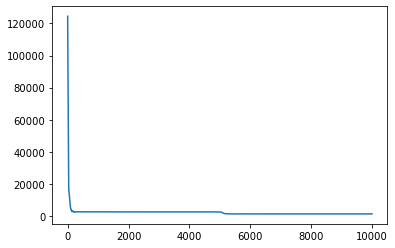

In [3]:
#train model using priors and MAP
from hysteresis.bayesian import BayesianHysteresis, positional_covariance
from hysteresis.training import map_bayes, train_bayes
import pyro

def cov(model):
    return positional_covariance(model, 1.0)

bh = BayesianHysteresis(train_h=h_train, train_m=m_train, mesh_scale=0.5)


guide, trace = map_bayes(bh, 10000, initial_lr=0.1)
plt.plot(trace)

C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\pyro\primitives.py:440: UserWarning: poly_fit.weights was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\pyro\primitives.py:440: UserWarning: poly_fit.bias was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(


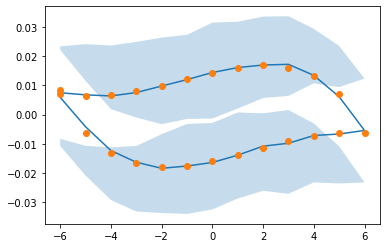

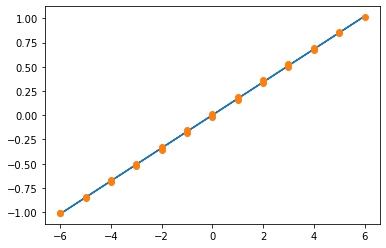

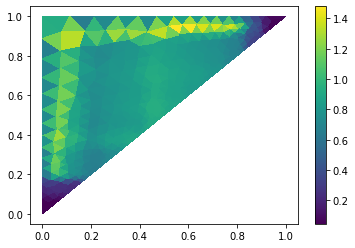

In [4]:
# make predictions
from hysteresis.bayesian_utils import predict, save_predictive, load_predictive
from hysteresis.visualization import plot_hysteresis_density
pred_summary, samples = predict(h_train, bh, guide)
mean = pred_summary['obs']['mean']
l = pred_summary['obs']['5%']
u = pred_summary['obs']['95%']

fit_val = bh.transformer.poly_fit(h_train)

fig, ax = plt.subplots()
ax.plot(h_train, mean.detach() - fit_val)
ax.plot(h_train, m_train.detach() - fit_val,'o')
ax.fill_between(h_train, l - fit_val, u - fit_val, alpha=0.25)

fig2, ax2 = plt.subplots()
ax2.plot(h_train, fit_val.detach())
ax2.plot(h_train, m_train,'o')

fig3, ax3 = plot_hysteresis_density(
    bh,
    pred_summary['density']['mean'].flatten().detach()
)

(tensor([0.0000, 0.0101, 0.0202, 0.0303, 0.0404, 0.0505, 0.0606, 0.0707, 0.0808,
        0.0909, 0.1010, 0.1111, 0.1212, 0.1313, 0.1414, 0.1515, 0.1616, 0.1717,
        0.1818, 0.1919, 0.2020, 0.2121, 0.2222, 0.2323, 0.2424, 0.2525, 0.2626,
        0.2727, 0.2828, 0.2929, 0.3030, 0.3131, 0.3232, 0.3333, 0.3434, 0.3535,
        0.3636, 0.3737, 0.3838, 0.3939, 0.4040, 0.4141, 0.4242, 0.4343, 0.4444,
        0.4545, 0.4646, 0.4747, 0.4848, 0.4949, 0.5051, 0.5152, 0.5253, 0.5354,
        0.5455, 0.5556, 0.5657, 0.5758, 0.5859, 0.5960, 0.6061, 0.6162, 0.6263,
        0.6364, 0.6465, 0.6566, 0.6667, 0.6768, 0.6869, 0.6970, 0.7071, 0.7172,
        0.7273, 0.7374, 0.7475, 0.7576, 0.7677, 0.7778, 0.7879, 0.7980, 0.8081,
        0.8182, 0.8283, 0.8384, 0.8485, 0.8586, 0.8687, 0.8788, 0.8889, 0.8990,
        0.9091, 0.9192, 0.9293, 0.9394, 0.9495, 0.9596, 0.9697, 0.9798, 0.9899,
        1.0000]), None)


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\pyro\primitives.py:440: UserWarning: poly_fit.weights was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\pyro\primitives.py:440: UserWarning: poly_fit.bias was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(


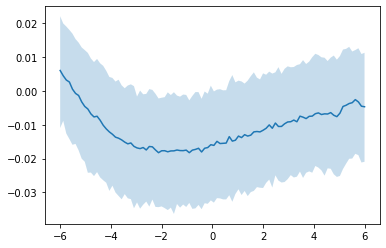

In [6]:
from hysteresis.bayesian_utils import summary
save_predictive(bh, guide)
pred = load_predictive('predictive.pt')
pred.model.future()

domain = pred.model.valid_domain
test_h = torch.linspace(*domain, 100)
norm_h = pred.model.transformer.transform(test_h)

samples = pred(test_h, return_real = True)
result = summary(samples)

fit_val = bh.transformer.poly_fit(test_h)
plt.plot(test_h, result['obs']['mean'] - fit_val)
plt.fill_between(test_h,
                 result['obs']['5%'] - fit_val,
                 result['obs']['95%'] - fit_val, alpha=0.25)